# Classify using Deep Learning

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
inoutpath = 'data/'

train_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_train.csv'
test_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_test.csv'

epochs = 5

## Load data

In [3]:
def load_data(compdata_path):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Loading data ...")
    papers = pd.read_csv(compdata_path, index_col=False)
    papers.drop(['Unnamed: 0'], axis=1, inplace=True)

    return papers.fillna(0)

In [4]:
X = load_data(train_data_path)
X_lxd = load_data(test_data_path)

2021-07-26 00:07:42.861533: Loading data ...
2021-07-26 00:07:43.706821: Loading data ...


/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
len(X.index)

17519

In [7]:
y = X.is_published

In [8]:
print(X.columns.values)

['title' 'abstract' 'journal' 'DOI' 'date' 'collection' 'published'
 'nauthors' 'keywords' 'topic.Clinics' 'topic.Genomics' 'topic.Imaging'
 'topic.Healthcare' 'topic.Drug discovery' 'topic.Epidemiology' 'topic'
 'ref' 'p_doi' 'dv 1' 'dv 2' 'dv 3' 'dv 4' 'dv 5' 'dv 6' 'dv 7' 'dv 8'
 'dv 9' 'dv 10' 'dv 11' 'dv 12' 'dv 13' 'dv 14' 'dv 15' 'dv 16' 'dv 17'
 'dv 18' 'dv 19' 'dv 20' 'dv 21' 'dv 22' 'dv 23' 'dv 24' 'dv 25' 'dv 26'
 'dv 27' 'dv 28' 'dv 29' 'dv 30' 'dv 31' 'dv 32' 'dv 33' 'dv 34' 'dv 35'
 'dv 36' 'dv 37' 'dv 38' 'dv 39' 'dv 40' 'dv 41' 'dv 42' 'dv 43' 'dv 44'
 'dv 45' 'dv 46' 'dv 47' 'dv 48' 'dv 49' 'dv 50' 'dw 1' 'dw 2' 'dw 3'
 'dw 4' 'dw 5' 'dw 6' 'dw 7' 'dw 8' 'dw 9' 'dw 10' 'dw 11' 'dw 12' 'dw 13'
 'dw 14' 'dw 15' 'dw 16' 'dw 17' 'dw 18' 'dw 19' 'dw 20' 'dw 21' 'dw 22'
 'dw 23' 'dw 24' 'dw 25' 'dw 26' 'dw 27' 'dw 28' 'dw 29' 'dw 30' 'dw 31'
 'dw 32' 'dw 33' 'dw 34' 'dw 35' 'dw 36' 'dw 37' 'dw 38' 'dw 39' 'dw 40'
 'dw 41' 'dw 42' 'dw 43' 'dw 44' 'dw 45' 'dw 46' 'dw 47' 'dw 4

## Train DL model

In [9]:
def create_model(n_features, layers):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(layers[0], input_dim=n_features, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))

    # add hidden layers
    for i in range(1, len(layers)):
        #model.add(tf.keras.layers.Dense(layers[i], activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
        model.add(tf.keras.layers.Dense(layers[i], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    return model

In [10]:
def eval_pred(y_true, y_prob, eval_type='Dev'):

    y_pred = y_prob >= 0.5
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_s = auc(fpr, tpr)

    prec, recall, f1_s, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    
    print(eval_type + ": AUC = %.3f, precision = %.3f, recall = %.3f, accuracy = %.3f, f1_score = %.3f" % (auc_s, prec, recall, acc, f1_s))

In [11]:
def dl_modeling(model_name, save_path, X_train, X_test, y_train, y_test, features, layers, epochs=10, batch_size=64):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Training {} model ...".format(model_name))
    model = create_model(len(features), layers)
    md = model.fit(X_train[features], y_train, epochs=epochs, batch_size=64)
    model.save(save_path + "model." + model_name + ".dl")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Evaluating {} model ...".format(model_name))
    y_test_prob = model.predict(X_test[features])
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc_dl = auc(fpr, tpr)
    eval_pred(y_train, model.predict(X_train[features]), 'Train')
    eval_pred(y_test, y_test_prob, 'Dev')
    
    return fpr, tpr, auc_dl

In [12]:
def draw_ROC_figure(fprs, tprs, f_names, aucs, save_path):
    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    
    for i in range(len(f_names)):
        plt.plot(fprs[i], tprs[i], label= f_names[i] +', AUC={:.4f}'.format(aucs[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.draw()
    fig1.savefig(save_path + "features_rocs.pdf")

### Compare feature and split train and test data

In [13]:
def feature_comparison(X_train, X_test, y_train, y_test, save_path, epochs=10):
    
    em_size = 50
    F_Doc2Vec = ['dv ' + str(i + 1) for i in range(em_size)]
    F_DeepWalk = ['dw ' + str(i + 1) for i in range(em_size)]
    F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Imaging', 'topic.Genomics']
    F_ascore = ['auth.papers.score', 'auth.citations.score']
    
    f_names = [
        'LDA+Doc2Vec+DeepWalk', 
        'Doc2Vec+DeepWalk', 
        'Doc2Vec+LDA', 
        'Doc2Vec', 
        'LDA', 
        'DeepWalk', 
    ]
    f_combs = [
        F_Doc2Vec + F_DeepWalk + F_LDA, 
        F_Doc2Vec + F_DeepWalk, 
        F_Doc2Vec + F_LDA, 
        F_Doc2Vec, 
        F_LDA, 
        F_DeepWalk
    ]
    layers = [
        [150, 30, 6, 9], 
        [150, 9, 20, 10], 
        [150, 9, 20, 10],
        [100, 50, 30, 10], 
        [10, 50, 3, 9], 
        [150, 6, 20, 3]
    ]
    
    fprs, tprs, aucs = [], [], []
    
    for i in range(len(f_names)):
        fpr, tpr, auc = dl_modeling(f_names[i], save_path, X_train, X_test, y_train, y_test, f_combs[i], layers[i], epochs=epochs)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)
        
    draw_ROC_figure(fprs, tprs, f_names, aucs, save_path)

14015
3504
2021-07-26 00:07:47.942722: Training LDA+Doc2Vec+DeepWalk model ...
Epoch 1/5
219/219 [==============================] - 1s 2ms/step - loss: 3.0361 - accuracy: 0.7558
Epoch 2/5
219/219 [==============================] - 0s 2ms/step - loss: 0.4995 - accuracy: 0.7886
Epoch 3/5
219/219 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.7927
Epoch 4/5
219/219 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7950
Epoch 5/5
219/219 [==============================] - 1s 2ms/step - loss: 0.4759 - accuracy: 0.7961
INFO:tensorflow:Assets written to: /home/xiaopengxu/Desktop/data-covid-review/2021-07-11/model.LDA+Doc2Vec+DeepWalk.dl/assets
2021-07-26 00:07:51.796847: Evaluating LDA+Doc2Vec+DeepWalk model ...
Train: AUC = 0.806, precision = 0.805, recall = 0.622, accuracy = 0.802, f1_score = 0.640
Dev: AUC = 0.768, precision = 0.772, recall = 0.603, accuracy = 0.790, f1_score = 0.614
2021-07-26 00:07:52.173076: Training Doc2Vec+DeepWal

/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: AUC = 0.692, precision = 0.376, recall = 0.500, accuracy = 0.751, f1_score = 0.429
Dev: AUC = 0.677, precision = 0.376, recall = 0.500, accuracy = 0.752, f1_score = 0.429
2021-07-26 00:08:07.181080: Training DeepWalk model ...
Epoch 1/5
219/219 [==============================] - 1s 2ms/step - loss: 2.3406 - accuracy: 0.7510
Epoch 2/5
219/219 [==============================] - 0s 2ms/step - loss: 0.5522 - accuracy: 0.7514
Epoch 3/5
219/219 [==============================] - 0s 2ms/step - loss: 0.5375 - accuracy: 0.7514
Epoch 4/5
219/219 [==============================] - 1s 2ms/step - loss: 0.5362 - accuracy: 0.7514
Epoch 5/5
219/219 [==============================] - 0s 2ms/step - loss: 0.5341 - accuracy: 0.7514
INFO:tensorflow:Assets written to: /home/xiaopengxu/Desktop/data-covid-review/2021-07-11/model.DeepWalk.dl/assets
2021-07-26 00:08:10.709033: Evaluating DeepWalk model ...


/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: AUC = 0.704, precision = 0.376, recall = 0.500, accuracy = 0.751, f1_score = 0.429
Dev: AUC = 0.661, precision = 0.376, recall = 0.500, accuracy = 0.752, f1_score = 0.429


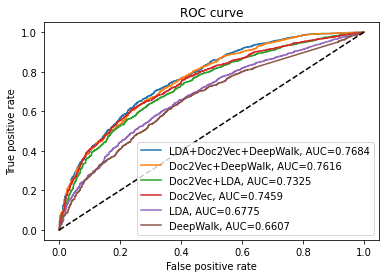

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.to_csv(inoutpath + 'training_set.csv')
X_test.to_csv(inoutpath + 'testing_set.csv')

print(len(X_train))
print(len(X_test))

feature_comparison(X_train, X_test, X_train.is_published, X_test.is_published, inoutpath, epochs=5)

In [21]:
F_Doc2Vec = ['dv ' + str(i + 1) for i in range(em_size)]
F_DeepWalk = ['dw ' + str(i + 1) for i in range(em_size)]
F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Imaging', 'topic.Genomics']

F_new = F_Doc2Vec + F_DeepWalk + F_LDA
# model.save(inoutpath + "model." + 'LDA+Doc2Vec+DeepWalk_selected_0.9-4-464' + ".dl")

def load_model(save_path, model_name):
    model = tf.keras.models.load_model(save_path + "model." + model_name + ".dl")
    return model

## Predict publishing probability on papers published last X=90 days

In [22]:
#X_train = pd.read_csv(inoutpath + 'training_set.csv')
#X_test = pd.read_csv(inoutpath + 'testing_set.csv')
model = load_model(inoutpath, 'LDA+Doc2Vec+DeepWalk_selected_0.9-4-464')

X['pub_prob'] = model.predict(X[F_new])
X_lxd['pub_prob'] = model.predict(X_lxd[F_new]) # target data

## Check the ranking of the selected preprints

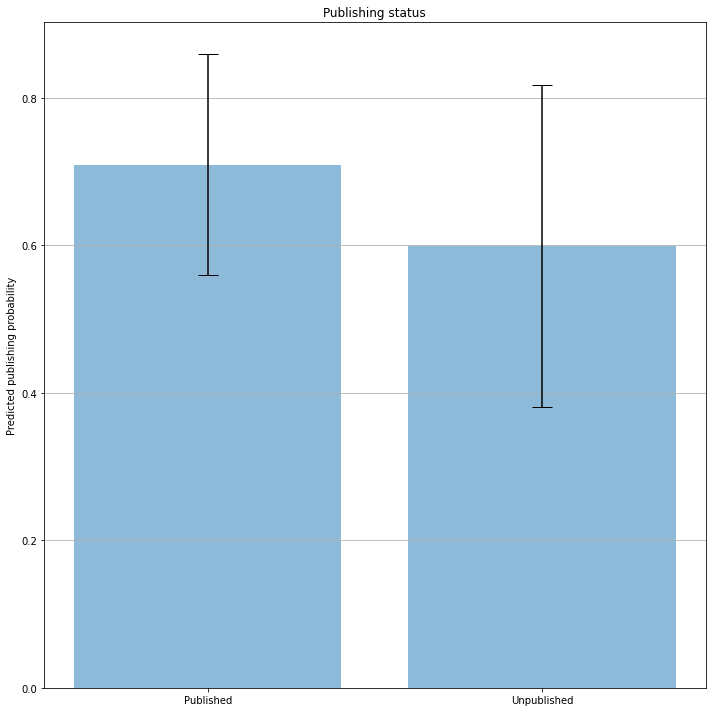

In [38]:
# Create lists for the plot
status = ['Published', 'Unpublished']
x_pos = np.arange(len(status))
CTEs = [X[X.is_preprint & X.is_published].pub_prob.mean(), X[X.is_preprint & ~X.is_published].pub_prob.mean()]
error = [X[X.is_preprint & X.is_published].pub_prob.std(), X[X.is_preprint & ~X.is_published].pub_prob.std()]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Predicted publishing probability')
ax.set_xticks(x_pos)
ax.set_xticklabels(status)
ax.set_title('Publishing status')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
fig3 = plt.gcf()
plt.draw()
fig3.savefig(inoutpath + "figs_dl_prediction_error_bar.pdf")
plt.show()

In [44]:
from sklearn.metrics import classification_report
target_names = ['Unpublished', 'Published']

print(classification_report(X_test.is_published, X_test.pub_prob >=0.5, target_names=target_names))

              precision    recall  f1-score   support

 Unpublished       0.86      0.20      0.32       869
   Published       0.79      0.99      0.88      2635

    accuracy                           0.79      3504
   macro avg       0.82      0.59      0.60      3504
weighted avg       0.81      0.79      0.74      3504



In [45]:
X_lxd.to_csv(inoutpath + "ret_lxd.ori_publishing_scores.csv")
X.to_csv(inoutpath + "ret.ori_publishing_scores.csv")

In [46]:
X_lxd['p_published'] = X_lxd.pub_prob > 0.592
X_lxd[X_lxd.p_published][['topic', 'p_published']].groupby('topic').count()

,p_published
topic,
Clinics,89
Drug discovery,127
Epidemiology,39
Genomics,98
Healthcare,57
Imaging,12


## Analyze prediction among Topics

<AxesSubplot:xlabel='topic'>

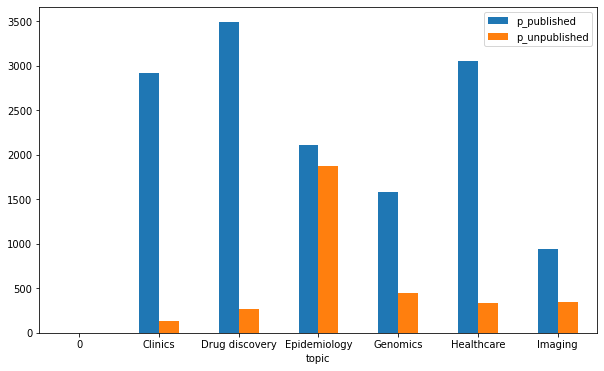

In [48]:
plt.rcParams['figure.figsize'] = [10, 6]

X['p_published'] = (X['pub_prob'] > 0.592) * 1
df_ret = pd.merge(X['topic'], X['p_published'], left_index=True, right_index=True)

topic_sum = df_ret.groupby('topic').agg({'topic':'count', 'p_published':'sum'})
topic_sum['p_unpublished'] = topic_sum['topic'] - topic_sum['p_published']
topic_sum[['p_published', 'p_unpublished']].plot.bar(rot=0)

<AxesSubplot:xlabel='topic'>

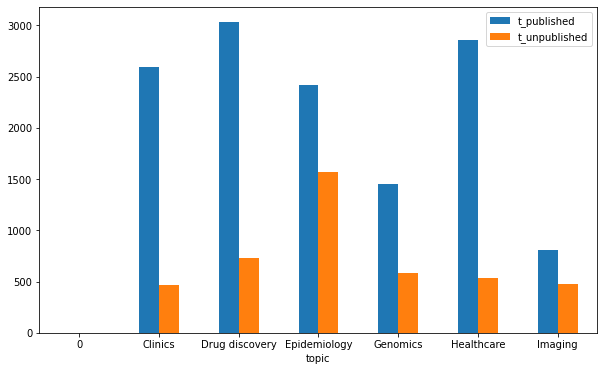

In [49]:
X['t_published'] = y * 1
df_t_ret = pd.merge(X['topic'], X['t_published'], left_index=True, right_index=True)

topic_t_sum = df_t_ret.groupby('topic').agg({'topic':'count', 't_published':'sum'})
topic_t_sum['t_unpublished'] = topic_t_sum['topic'] - topic_t_sum['t_published']
topic_t_sum[['t_published', 't_unpublished']].plot.bar(rot=0)